In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
%run ../src/core.py
%run ../src/lpf.py
%run ../extcore.py

In [3]:
from scipy.signal import medfilt as MF
from scipy.stats import scoreatpercentile as sap

In [4]:
N = lambda a: a/median(a)

In [12]:
class LPFC(LPF):
    def __init__(self, use_ldtk=False, constant_k=True, noise='white'):
        pbs = 'g r i z'.split()
        cols = ['relative_'+c for c in pbs]
        
        self.df1 = df1 = pd.merge(pd.read_hdf('../data/aux.h5','aug25'),
                                  pd.read_hdf('../results/gtc_light_curves.h5','broadband/night2'),
                                  left_index=True, right_index=True)
        
        times  = 4*[df1['mjd-obs'].values+2400000.5-TZERO]
        fluxes = df1[cols].values.T
        
        super(LPFC,self).__init__(times, fluxes, pbs, 
                                  use_ldtk=use_ldtk, constant_k=constant_k, noise=noise)
        
        ## Mask outliers
        ## -------------
        lims = [0.006, 0.003, 0.005, 0.005]
        mask = ones(self.fluxes[0].size, np.bool)
        for i in range(4):
            f = self.fluxes[i]
            mask &= abs(f-MF(f,11)) < lims[i]
        self.mask = mask
        
        self.times   = [self.times[i][self.mask]  for i in range(4)]
        self.fluxes  = [self.fluxes[i][self.mask] for i in range(4)]
        self.rotang  = df1.rotang[self.mask]
        self.elevat  = df1.elevat[self.mask]
        self.airmass = df1.airmass[self.mask]
        self.ctimes  = [t-t.mean() for t in self.times]
        
        ## Setup priors
        ## ------------
        ## Basic parameters
        ## ----------------
        self.priors = [NP(    TC,   5e-3,   'tc'), ##  0  - Transit centre
                       NP(     P,   3e-4,    'p'), ##  1  - Period
                       UP(  3.50,   4.50,  'rho'), ##  2  - Stellar density
                       UP(  0.00,   0.99,    'b')] ##  3  - Impact parameter
        
        ## Area ratio
        ## ----------
        self._sk2 = len(self.priors)
        if constant_k:
            self.priors.append( UP(0.16**2, 0.18**2, 'k2')) ##  4  - planet-star area ratio
        else:
            self.priors.extend([UP(0.16**2, 0.18**2, 'k2_%i'%ipb) 
                                for ipb in range(self.npb)]) ##  4  - planet-star area ratio
            
        ## Limb darkening
        ## --------------
        self._sq1 = len(self.priors)
        self._sq2 = self._sq1+1
        for ipb in range(self.npb):
            self.priors.extend([UP(0, 1, 'q1_%i'%ipb),      ##  sq1 + 2*ipb -- limb darkening q1
                                UP(0, 1, 'q2_%i'%ipb)])     ##  sq2 + 2*ipb -- limb darkening q2
            
        ## Baseline constant
        ## -----------------
        self._sbl = len(self.priors)
        for ilc in range(self.nlc):
            self.priors.append(NP(1, 1e-4, 'bla_%i'%ilc)) ##  sbl + ilc -- Baseline constant
            self.priors.append(UP(-0.15, 0.02, 'blb_%i'%ilc)) ##  sbl + ilc -- Linear baseline
        
        ## White noise
        ## -----------
        self._swn = len(self.priors)
        if noise == 'white':
            self.priors.extend([UP(1e-4, 1e-2, 'e_%i'%ilc) 
                                for ilc in range(self.nlc)]) ##  sqn + ilc -- Average white noise
        self.ps = PriorSet(self.priors)
        self.set_pv_indices()
        
        
        fc = pd.read_hdf(join('..',result_file), 'ckrn_ldtk/fc')
        self.priors[0] = NP(fc.tc.mean(),   fc.tc.std(),  'tc',  limsigma=100)
        self.priors[1] = NP(fc.p.mean(),    fc.p.std(),   'p',   limsigma=100)
        self.priors[2] = NP(fc.rho.mean(),  fc.rho.std(), 'rho', limsigma=100)
        self.priors[3] = NP(fc.b.mean(),    fc.b.std(),   'b',   lims=(0,1))
        
        if constant_k:
            self.priors[4] = NP(fc.k2.mean(),   fc.k2.std(), 'k2',   limsigma=100)
        else:
            for i in self.ik2:
                self.priors[i] = NP(fc.k2.mean(), fc.k2.std(), 'k2_%i'%i,   limsigma=100)
                
        for i in self.ibla:
            self.priors[i] = NP(1.0, 6e-3, 'e_%i'%i)
        for i in self.iwn:
            self.priors[i] = UP(1e-4, 1e-3, 'e_%i'%i)
        self.ps = PriorSet(self.priors)
        
        self.setup_gp()
        
        
    def set_pv_indices(self, sbl=None, swn=None):
        if self.constant_k:
            self.ik2 = [self._sk2]
        else:
            self.ik2 = [self._sk2+pbid for pbid in self.gpbids]
                        
        self.iq1 = [self._sq1+pbid*2 for pbid in self.gpbids]
        self.iq2 = [self._sq2+pbid*2 for pbid in self.gpbids]
        
        sbl = sbl if sbl is not None else self._sbl
        self.ibla = [sbl+2*ilc   for ilc in range(self.nlc)]
        self.iblb = [sbl+2*ilc+1 for ilc in range(self.nlc)]

        if self.noise == 'white':
            swn = swn if swn is not None else self._swn
            self.iwn = [swn+ilc for ilc in range(self.nlc)]
        else:
            self.iwn = []

        
    def setup_gp(self):
        self.wn = wn = array([-2.89, -3.23, -3.17, -3.2])
        self.gps = [GPTime(t,f) for t,f in zip(self.times, self.fluxes)]
        [gp.compute([-2.27, 0.3, wn[i]]) for i,gp in enumerate(self.gps)]
        
        
    def lnlikelihood_rn(self, pv):
        flux_m = self.compute_lc_model(pv)
        return sum([gp.gp.lnlikelihood(fo-fm) for gp,fo,fm in zip(self.gps,self.fluxes,flux_m)])
        
        
    def compute_baseline(self, pv):
        return [pv[ia] + pv[ib]*t for ia,ib,t in zip(self.ibla,self.iblb,self.ctimes)]

In [13]:
lpf = LPFC(noise='red', constant_k=False)

In [14]:
de = DiffEvol(lpf.lnposterior, lpf.ps.bounds, 100, maximize=True)
fc = pd.read_hdf(join('..',result_file), 'vkrn_ldtk/fc')
sample = permutation(fc)[:de.n_pop]
de._population[:, 0:8] = sample[:,0:8]

In [15]:
de.population[:,lpf.iblb].mean(0)

array([-0.06536013, -0.06895182, -0.06997813, -0.06925582])

In [19]:
de.optimize(250)

(array([  1.25416592e+02,   3.06783868e+00,   4.02660701e+00,
          1.19172476e-01,   2.92161079e-02,   2.92217240e-02,
          2.92500444e-02,   2.92313427e-02,   9.89177743e-01,
          2.90129212e-01,   9.32650040e-01,   2.69897002e-01,
          7.96049371e-01,   1.58807662e-01,   7.36323706e-01,
          1.41130294e-01,   1.00656293e+00,  -1.26037818e-03,
          1.00699862e+00,  -2.08128111e-02,   1.00659279e+00,
         -2.43923349e-02,   1.00518317e+00,  -3.87054083e-03]),
 -13246.592207333631)

(array([  2.,   5.,  12.,  18.,  21.,  19.,   9.,   6.,   5.,   3.]),
 array([-13246.59220733, -13246.520934  , -13246.44966066, -13246.37838732,
        -13246.30711398, -13246.23584064, -13246.16456731, -13246.09329397,
        -13246.02202063, -13245.95074729, -13245.87947395]),
 <a list of 10 Patch objects>)

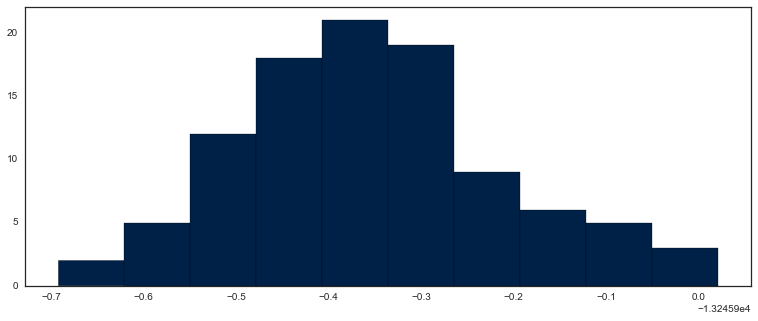

In [20]:
hist(de._fitness)

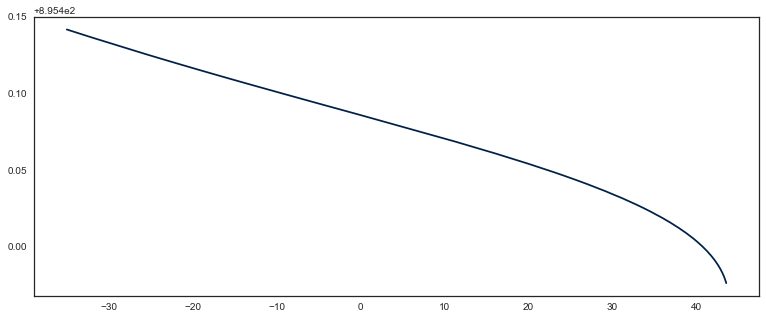

In [127]:
plot(lpf.rotang, lpf.times[0])

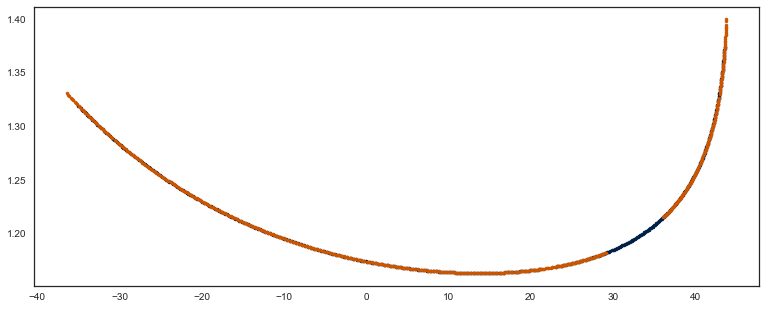

In [97]:
plot(lpf.rotang, lpf.airmass, '.')
plot(t['arr_0'], t['arr_2'], '.')

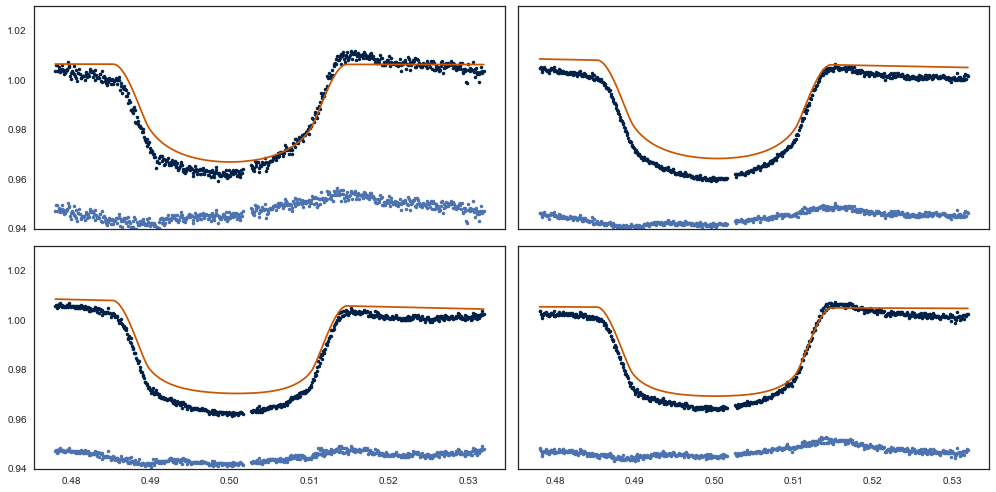

In [21]:
pv = de.minimum_location
fms = lpf.compute_lc_model(pv)
fos = lpf.fluxes
fig,axs = subplots(2,2,figsize=(14,7), sharey=True, sharex=True)
for i in range(4):
    phase = fold(lpf.times[i], pv[1], pv[0], 0.5)
    res = fos[i]-fms[i]
    axs.flat[i].plot(phase, fos[i], '.')
    axs.flat[i].plot(phase, fms[i])
    axs.flat[i].plot(phase, res+0.95, '.')
setp(axs, ylim=(0.94,1.03))
fig.tight_layout()

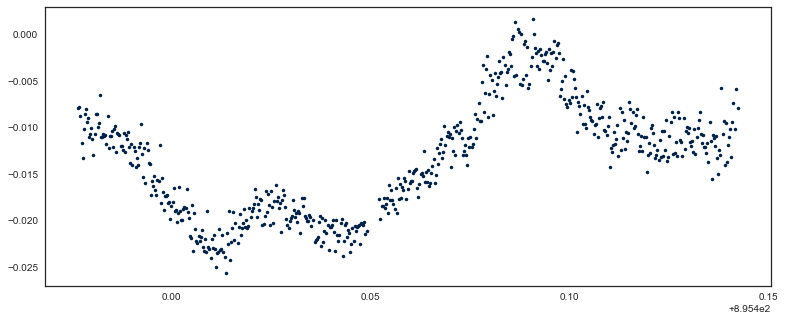

In [27]:
plot(lpf.times[0], sum(fos[1:],0)-sum(fms[1:],0), '.')

In [94]:
t = load('test.npz')

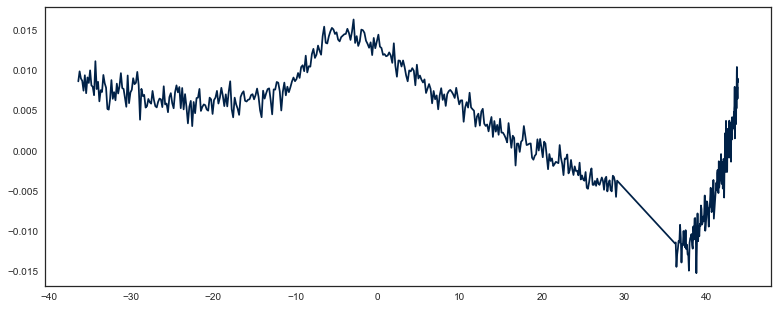

In [66]:
plot(t['arr_0'], t['arr_2'])

In [41]:
gp = GPTime(lpf.rotang, sum(fos[1:],0)-sum(fms[1:],0))

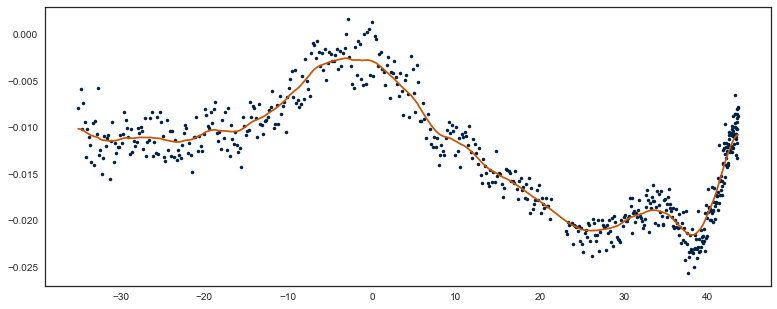

In [50]:
gp.compute([-3, 1e-5, -3.5])
plot(lpf.rotang, sum(fos[1:],0)-sum(fms[1:],0), '.')
plot(lpf.rotang, gp.predict())

In [86]:
gp = GPTime(ra,re)

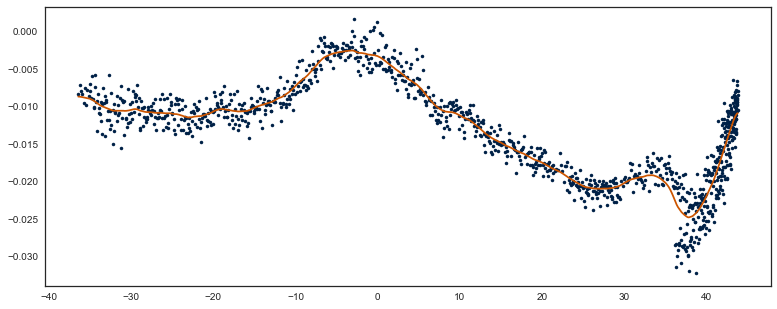

In [87]:
gp.compute([-3, 1e-5, -3.5])
plot(ra, re, '.')
plot(ra, gp.predict())

In [69]:
pv

array([  1.25416592e+02,   3.06783868e+00,   4.02660701e+00,
         1.19172476e-01,   2.92161079e-02,   2.92217240e-02,
         2.92500444e-02,   2.92313427e-02,   9.89177743e-01,
         2.90129212e-01,   9.32650040e-01,   2.69897002e-01,
         7.96049371e-01,   1.58807662e-01,   7.36323706e-01,
         1.41130294e-01,   1.00656293e+00,  -1.26037818e-03,
         1.00699862e+00,  -2.08128111e-02,   1.00659279e+00,
        -2.43923349e-02,   1.00518317e+00,  -3.87054083e-03])

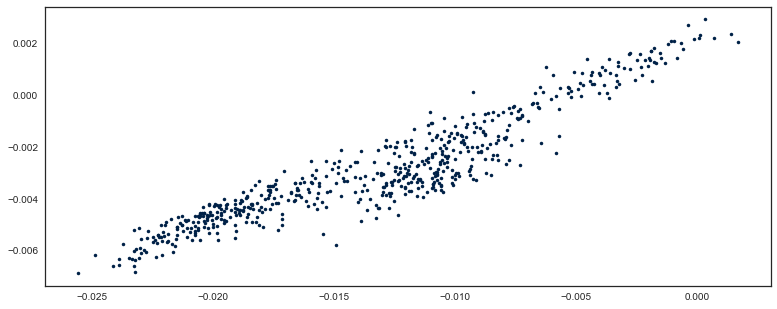

In [82]:
i = 3
plot(sum(fos[1:],0)-sum(fms[1:],0), fos[i]-fms[i], '.')

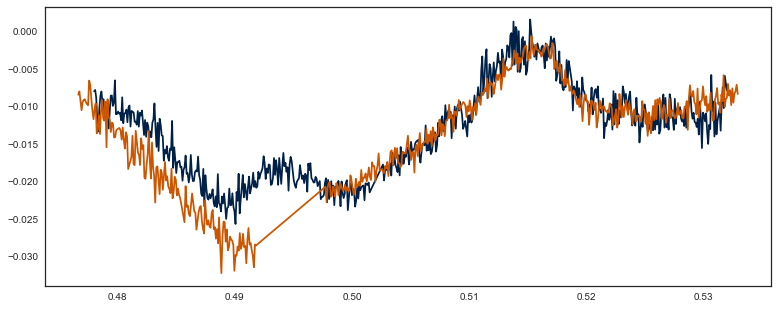

In [75]:
plot(fold(lpf.times[0], pv[1], pv[0], 0.5), sum(fos[1:],0)-sum(fms[1:],0))
plot(0.003+fold(t['arr_1'], pv[1], pv[0], 0.5), t['arr_2']-0.017)

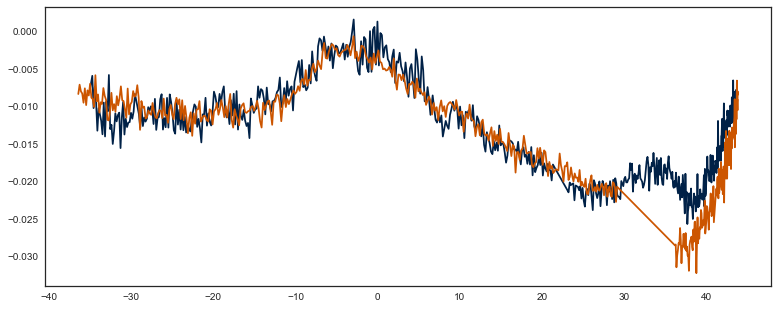

In [180]:
plot(lpf.rotang, sum(fos[1:],0)-sum(fms[1:],0))
#plot(t['arr_0'], t['arr_3'])#*exp(-0.05*t['arr_2'])-0.017)
plot(t['arr_0'], t['arr_3']-0.017)

In [164]:
ra2, am2 = t['arr_0'], t['arr_2']

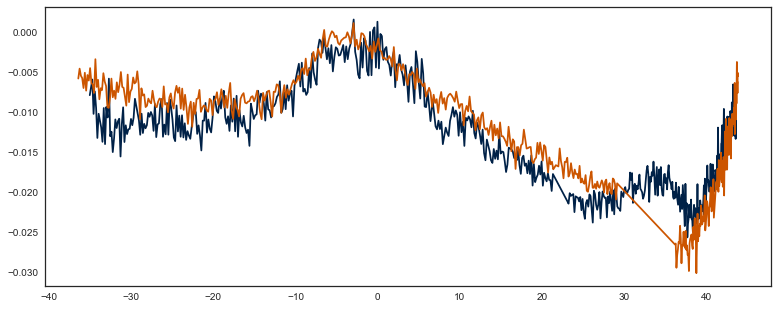

In [177]:
plot(lpf.rotang, sum(fos[1:],0)-sum(fms[1:],0))
plot(ra2, t['arr_3']+0.002*am2**2-0.018)
#plot(t['arr_0'], t['arr_3']-0.017)

In [83]:
ra1,ra2 = lpf.rotang, t['arr_0']
re1,re2 = sum(fos[1:],0)-sum(fms[1:],0), t['arr_2']-0.017

In [84]:
ra = concatenate([ra1,ra2])
re = concatenate([re1,re2])
si = argsort(ra)
ra,re = ra[si], re[si]

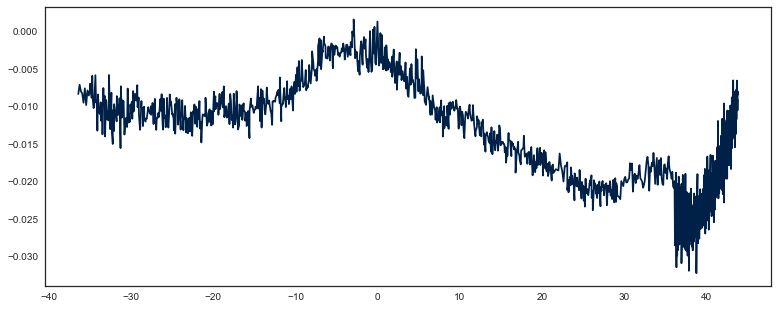

In [85]:
plot(ra,re)

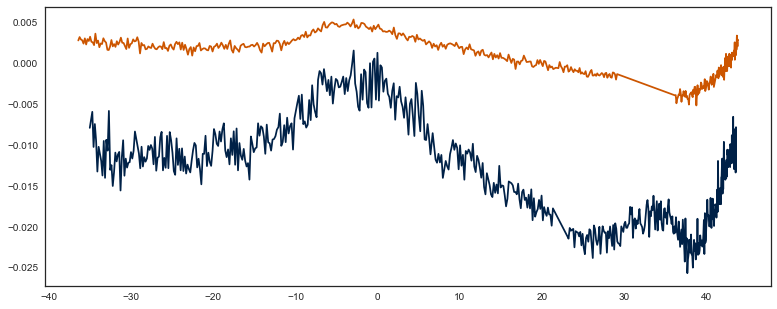

In [54]:
plot(lpf.rotang, sum(fos[1:],0)-sum(fms[1:],0))
plot(t['arr_0'], t['arr_1']/3)

In [213]:
sampler = EnsembleSampler(de.n_pop, de.n_par, lpf.lnposterior)

In [214]:
sampler.run_mcmc(de.population, 25);

In [215]:
sampler.run_mcmc(sampler.chain[:,-1,:], 225);

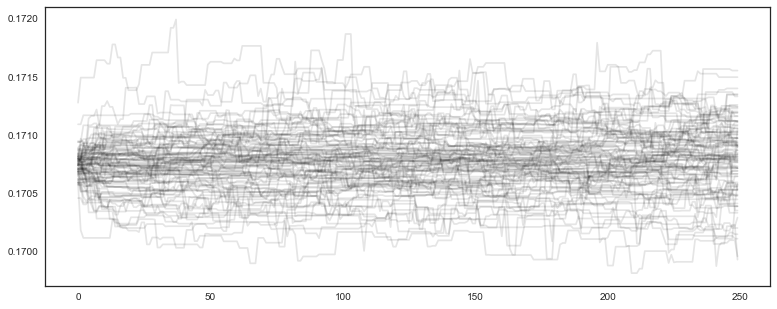

In [216]:
plot(sqrt(sampler.chain[:,:,4].T), 'k', alpha=0.1);

In [217]:
dff = pd.DataFrame(sampler.chain[:,100::10,:].reshape([-1,lpf.ps.ndim]), columns=lpf.ps.names)

In [218]:
dfo = pd.read_hdf('../'+result_file, 'ckrn_ldtk/fc')

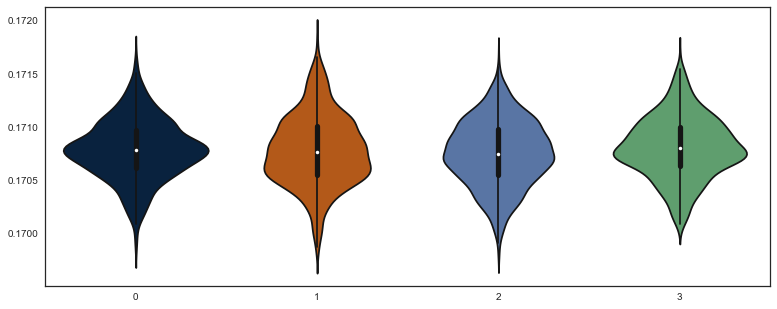

In [219]:
sb.violinplot(data=transpose([sqrt(dff.icol(i)) for i in range(4,8)]))

In [220]:
sqrt(lpf.priors[5].limits())

array([ 0.13514714,  0.20005421])

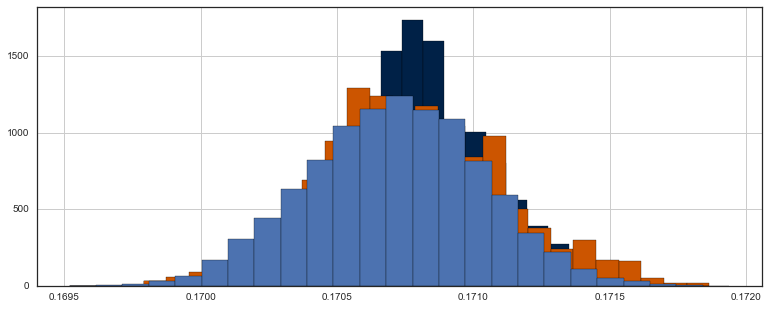

In [221]:
sqrt(dff.k2_4).hist(bins=25, normed=True)
sqrt(dff.k2_5).hist(bins=25, normed=True)
sqrt(dfo.k2).hist(bins=25, normed=True)

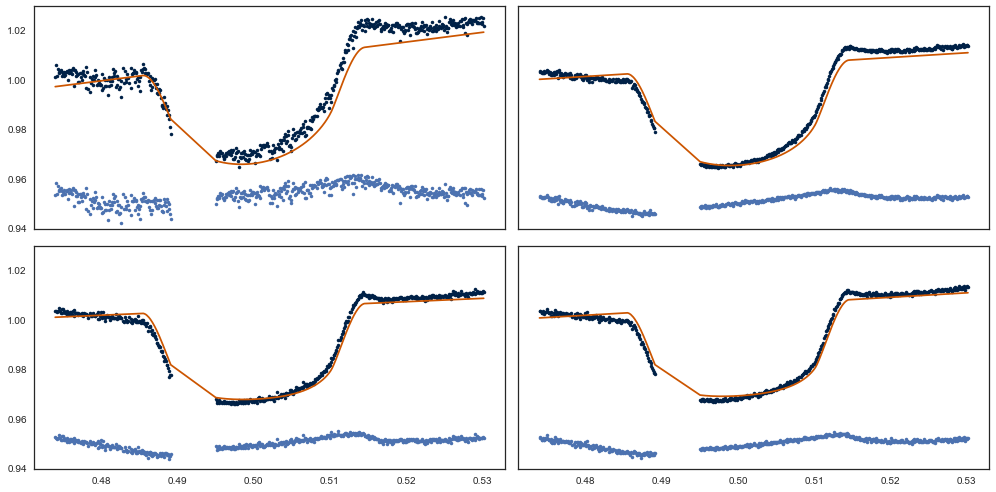

In [182]:
pv = median(sampler.chain[:,100::10,:].reshape([-1,lpf.ps.ndim]),0)
fms = lpf.compute_lc_model(pv)
fos = lpf.fluxes
fig,axs = subplots(2,2,figsize=(14,7), sharey=True, sharex=True)
for i in range(4):
    phase = fold(lpf.times[i], pv[1], pv[0], 0.5)
    res = fos[i]-fms[i]
    axs.flat[i].plot(phase, fos[i], '.')
    axs.flat[i].plot(phase, fms[i])
    axs.flat[i].plot(phase, res+0.95, '.')
setp(axs, ylim=(0.94,1.03))
fig.tight_layout()

In [176]:
phase = fold(lpfc.times[3], mp[1], mp[0], 0.5)
phasem = fold(df1['mjd-obs'].values+2400000.5-TZERO, mp[1], mp[0], 0.5)
otmask = abs(phase - 0.5) < 0.017

In [177]:
emax = argmax(lpf1.elevat[3].values)

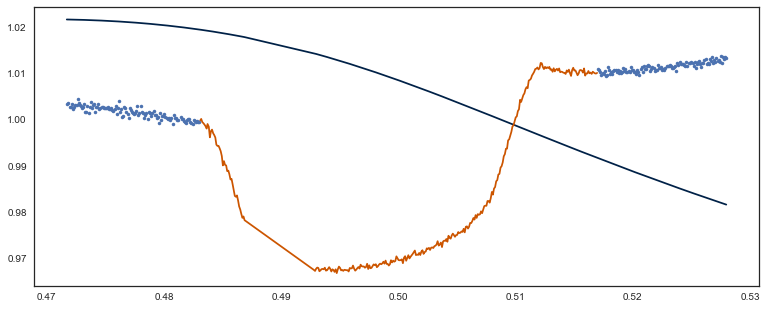

In [178]:
plot(phase, 1+0.0005*lpf1.rotang[3])
plot(phase[otmask], lpfc.fluxes[3][otmask])
plot(phase[~otmask], lpfc.fluxes[3][~otmask], '.')

In [235]:
gp = GPTime(lpfc.times[1][m],(fos[1]-fms[1])[m])

In [236]:
gp.priors = [UP(-3.5,  -2, 'log_ta'), ##  0  - log10 time amplitude
             UP(5e-2, 5e5,    'its'), ##  1  - inverse time scale
             UP(-4.0,  -2, 'log_wn')] ##  2  - log10 white noise
gp.ps = PriorSet(gp.priors)

In [237]:
gp.fit()

array([-2.27860519,  3.77378221, -3.35133224])

In [234]:
m = ones(lpfc.times[1].size, bool)
m[100:200] = False
m[320:400] = False

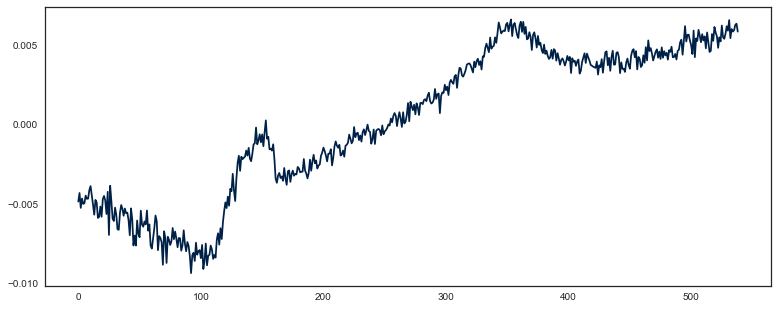

In [226]:
plot(gp.flux)

2160.37718163


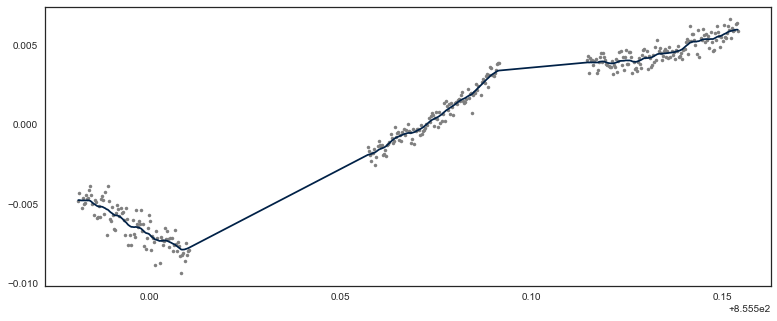

In [243]:
gp.compute([-2.29, 0.3, -3.26])
print gp.gp.lnlikelihood(gp.flux)
pr = gp.predict()
plot(gp.inputs, gp.flux, '.', c='0.5')
plot(gp.inputs, pr)

In [200]:
gp.fit()

array([  -2.66332043,  500.00000012,   -3.3952353 ])

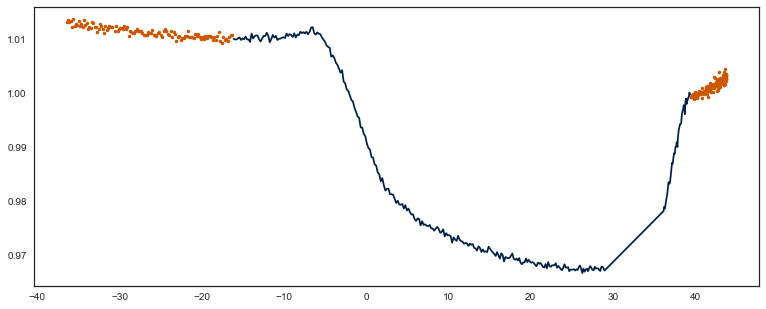

In [181]:
plot(lpf1.rotang[3].values[otmask], lpfc.fluxes[3][otmask])
plot(lpf1.rotang[3].values[~otmask], lpfc.fluxes[3][~otmask], '.')

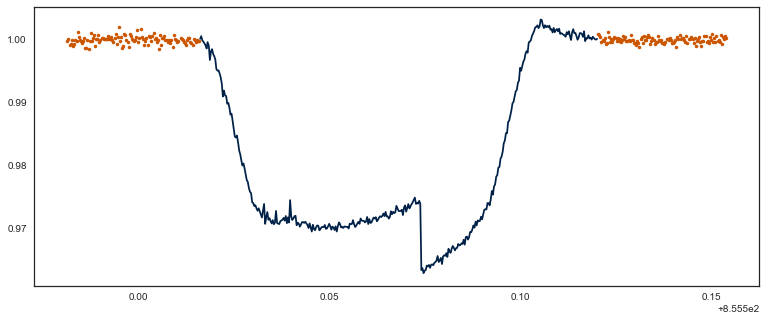

In [165]:
i = 3
phase = fold(lpfc.times[i], mp[1], mp[0], 0.5)
otmask = abs(phase - 0.5) < 0.017
amask = (~otmask) & (lpf1.times[i] < lpf1.times[i][emax])
bmask = (~otmask) & (lpf1.times[i] > lpf1.times[i][emax])
flux = lpf1.fluxes[i].copy()
time = lpf1.times[i].copy()
flux[:emax] /= poly1d(polyfit(lpf1.elevat[i].values[amask], flux[amask], 1))(lpf1.elevat[i].values[:emax])
flux[emax:] /= poly1d(polyfit(lpf1.elevat[i].values[bmask], flux[bmask], 1))(lpf1.elevat[i].values[emax:])
plot(lpf1.times[i][otmask],flux[otmask])
plot(lpf1.times[i][~otmask], flux[~otmask], '.')

In [158]:
res = [fo-fm for fo,fm in zip(fos,fms)]

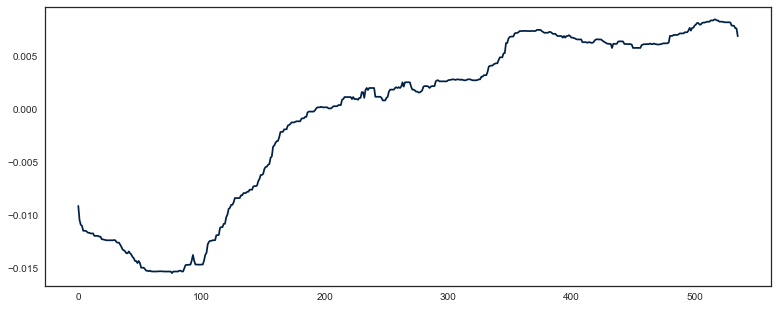

In [20]:
plot(MF(res[0],31))

In [28]:
np.round([log10((r-MF(r,31)).std()) for r in res],2)

array([-2.72, -3.32, -3.2 , -3.3 , -2.89, -3.23, -3.17, -3.2 ])

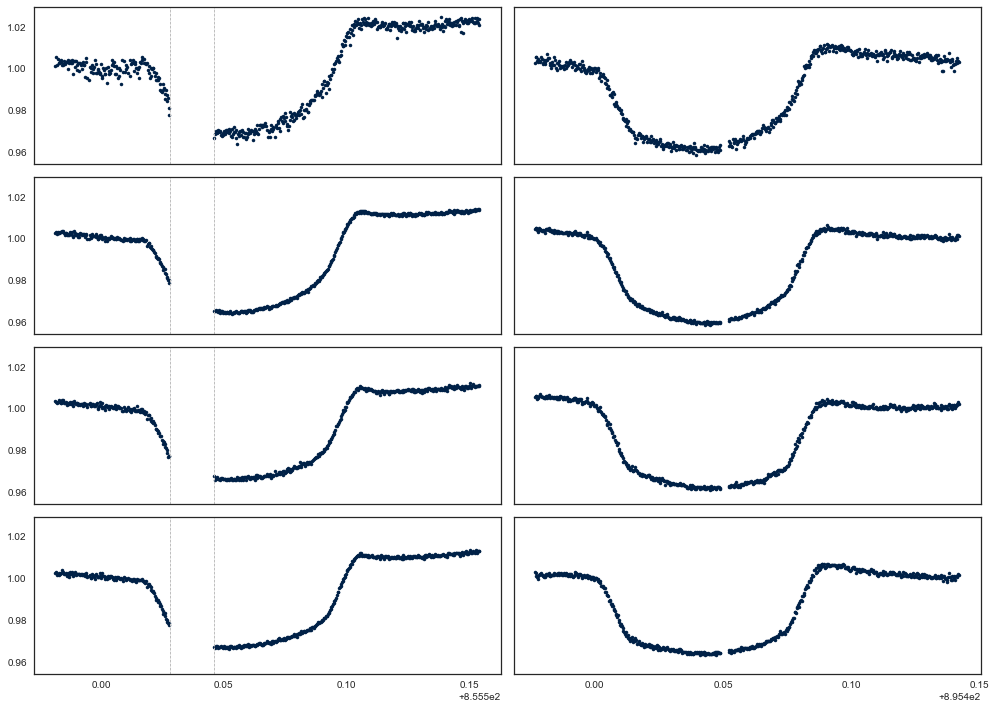

In [11]:
fig,axs = subplots(4,2,figsize=(14,10), sharey=True)
for i in range(4):
    axs[i,0].plot(lpf1.times[0],  lpf1.fluxes[i], '.')
    axs[i,1].plot(lpf2.times[0],  lpf2.fluxes[i], '.')
    axs[i,0].axvline(855.528, lw=1, ls='--', c='0.75')
    axs[i,0].axvline(855.546, lw=1, ls='--', c='0.75')
setp(axs[:-1,:], xticks=[])
setp(axs, ylim=(0.955,1.03))
fig.tight_layout()

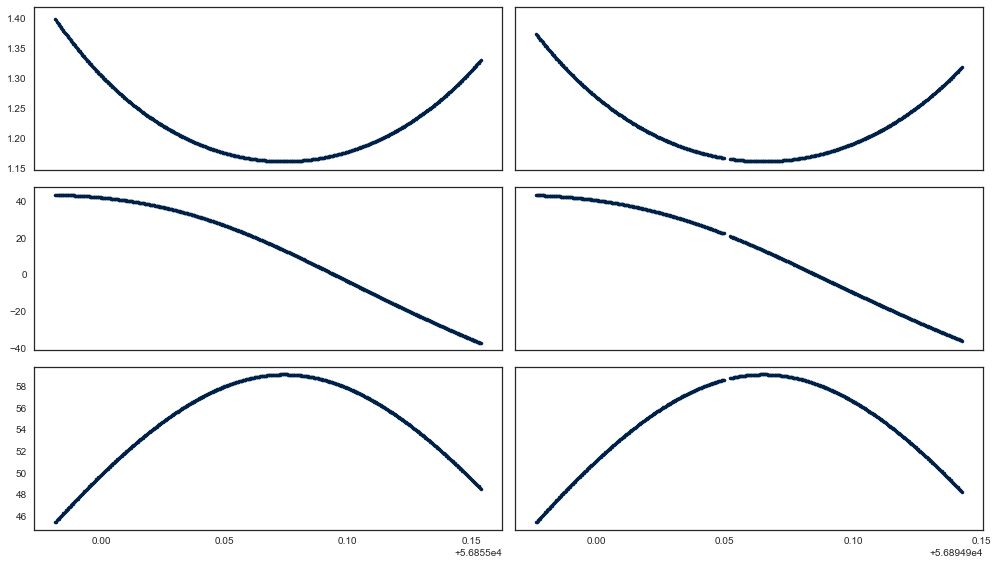

In [12]:
fig,axs = subplots(3,2,figsize=(14,8))
for i,k in enumerate('airmass rotang elevat'.split()):
    axs[i,0].plot(df1['mjd-obs'],  df1[k], '.')
    axs[i,1].plot(df2['mjd-obs'],  df2[k], '.')
setp(axs[:-1,:], xticks=[])
setp(axs[:,1], yticks=[])
setp(axs[0,:], ylim=(1.15,1.42))
setp(axs[1,:], ylim=(-40,48))
fig.tight_layout()

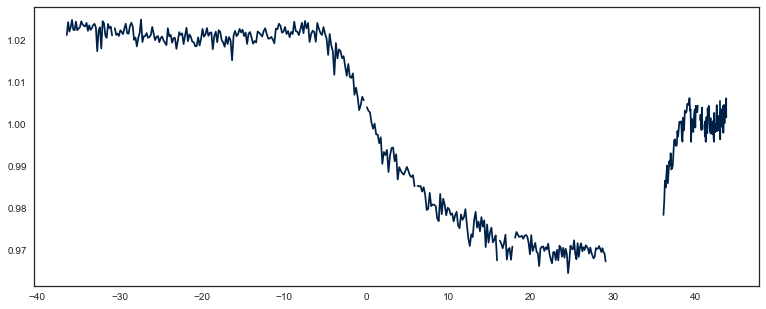

In [15]:
plot(df1.rotang, lpf1.fluxes[0])

In [43]:
pv0[lpf.iwn]

array([ 0.00986478,  0.00359903,  0.00888657,  0.00387348])

In [36]:
lpf1.ps.pmaxs

array([  1.25442523e+02,   3.06936100e+00,   4.50000000e+00,
         9.90000000e-01,   3.24000000e-02,   1.00000000e+00,
         1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
         1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
         1.00000000e+00,   1.00050000e+00,   1.00050000e+00,
         1.00050000e+00,   1.00050000e+00,   1.00000000e-02,
         1.00000000e-02,   1.00000000e-02,   1.00000000e-02])

In [38]:
lpf1.ps.pmins < pv0

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True], dtype=bool)

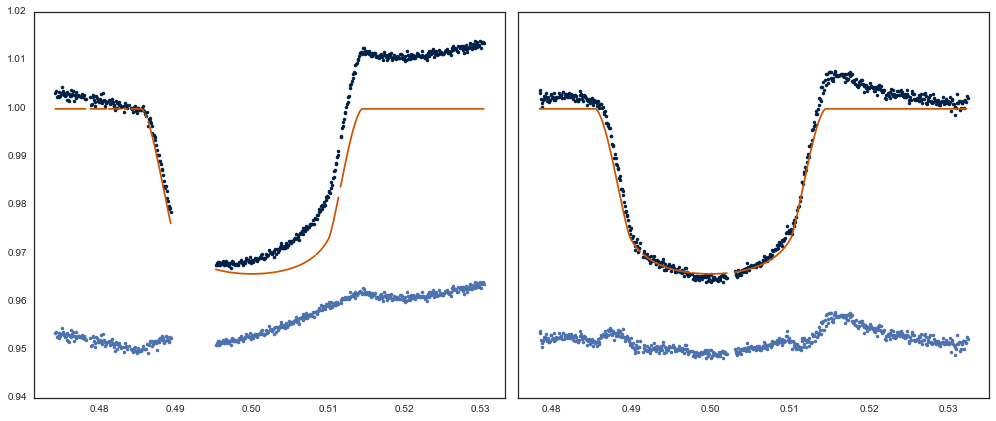

In [42]:
i = 3
fig,axs = subplots(1,2,figsize=(14,6), sharey=True)
for j,lpf in enumerate([lpf1,lpf2]):
    phase = fold(lpf.times[i], pv0[1], pv0[0], 0.5)
    fo = lpf.fluxes[i]
    fm = lpf.compute_lc_model(pv0)[i]
    res = fo-fm
    axs[j].plot(phase, fo, '.')
    axs[j].plot(phase, fm)
    axs[j].plot(phase, res+0.95, '.')
setp(axs, ylim=(0.94,1.02))
fig.tight_layout()

In [18]:
fm = lpf1.compute_lc_model(pv0)

(-0.01, 0.03)

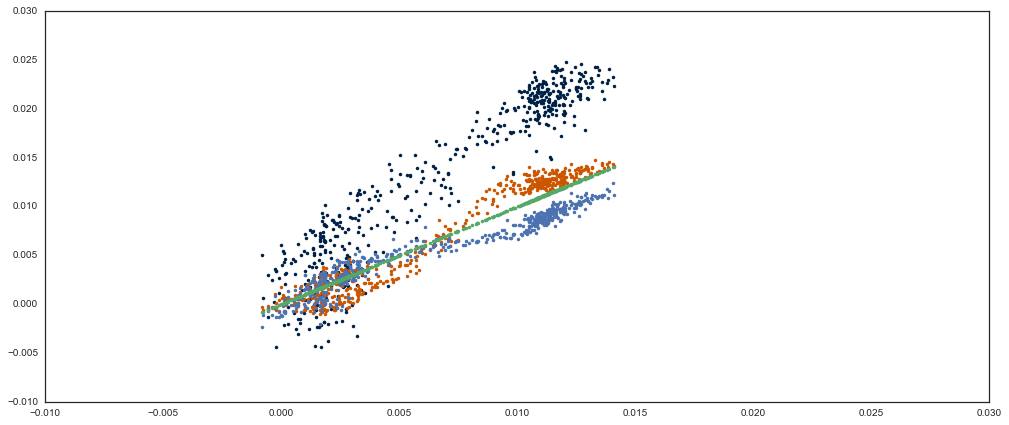

In [19]:
fig,axs = subplots(1,1,figsize=(14,6))
res = [lco-lcm for lco,lcm in zip(lpf1.fluxes,fm)]
for r in res:
    plot(res[-1], r, '.')
fig.tight_layout()
#ylim(0.99,1.03)
xlim(-0.01,0.03)
ylim(-0.01,0.03)

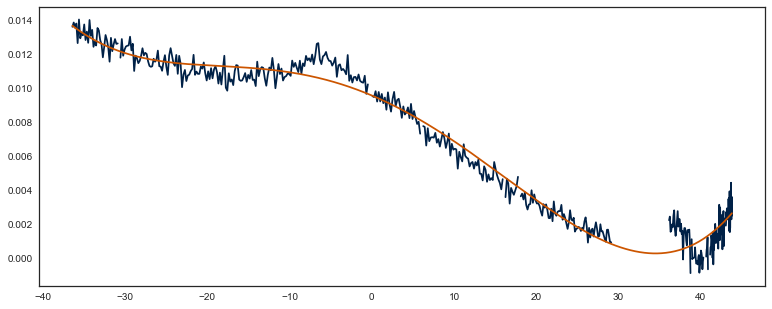

In [31]:
plot(df1.rotang, res[-1])
m = isfinite(res[-1])
plot(df1.rotang, poly1d(polyfit(df1.rotang[m], res[-1][m], 4))(df1.rotang))

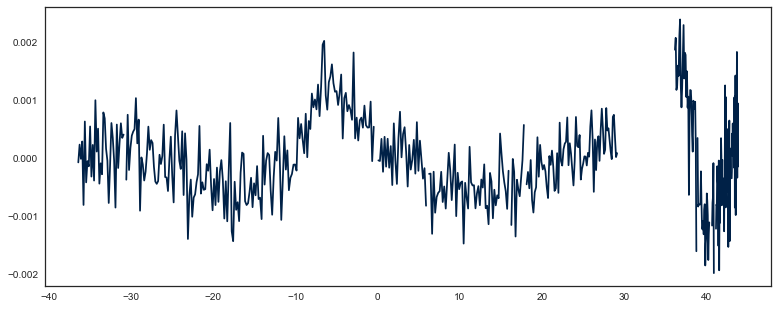

In [32]:
m = isfinite(res[-1])
plot(df1.rotang,res[-1]-poly1d(polyfit(df1.rotang[m], res[-1][m], 4))(df1.rotang))

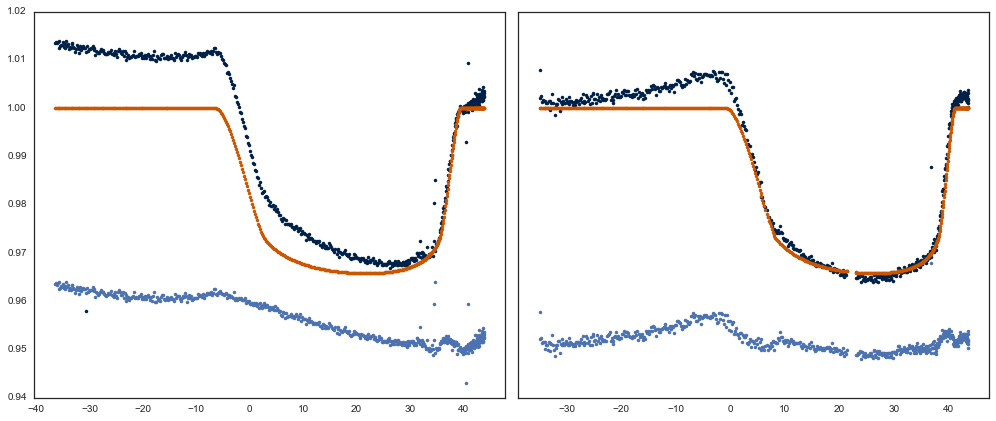

In [567]:
i = 3
fig,axs = subplots(1,2,figsize=(14,6), sharey=True)
for j,(df,lpf) in enumerate(zip([df1,df2],[lpf1,lpf2])):
    phase = fold(lpf.times[i], pv0[1], pv0[0], 0.5)
    fo = lpf.fluxes[i]
    fm = lpf.compute_transit(pv0)[i]
    res = fo-fm
    axs[j].plot(df.rotang, fo, '.')
    axs[j].plot(df.rotang, fm, '.')
    axs[j].plot(df.rotang, res+0.95, '.')
setp(axs, ylim=(0.94,1.02))
fig.tight_layout()

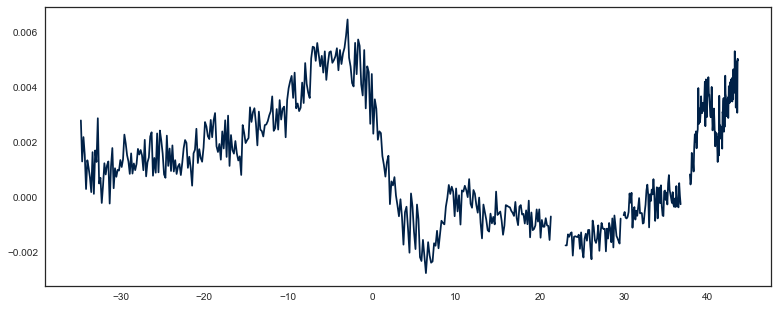

In [465]:
res = mean(lpf.fluxes[1:],0) - mean(lpf.compute_transit(pv0),0)
plot(f.rotang, res)

(-0.02, 0.03)

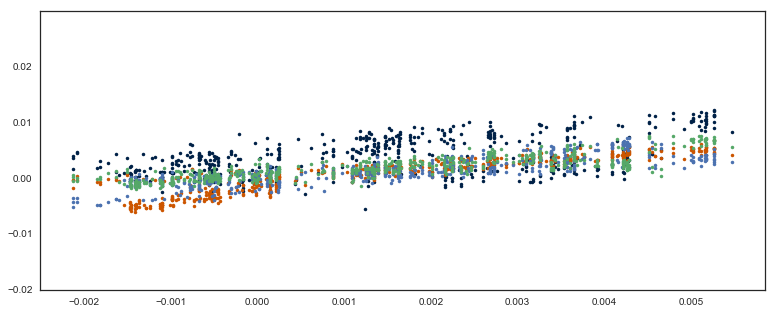

In [467]:
for i in range(4):
    plot(MF(res,11), lpf.fluxes[i]-lpf.compute_transit(pv0)[i], '.')
ylim(-0.02,0.03)

(-0.02, 0.03)

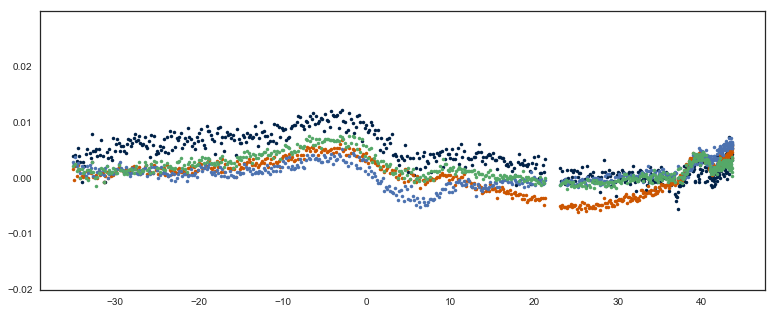

In [468]:
for i in range(4):
    plot(f.rotang, lpf.fluxes[i]-lpf.compute_transit(pv0)[i], '.')
ylim(-0.02,0.03)

(-0.02, 0.03)

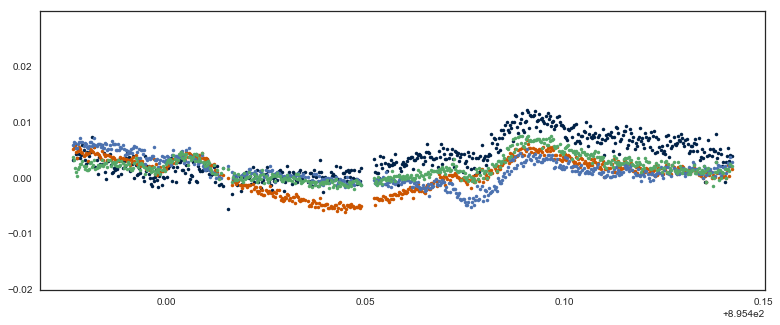

In [469]:
for i in range(4):
    plot(lpf.times[i], lpf.fluxes[i]-lpf.compute_transit(pv0)[i], '.')
ylim(-0.02,0.03)

In [ ]:
plot()

In [81]:
lpf.fluxes

,i,z
file_id,,
0000705536-20140825,1.006037,1.003742
0000705537-20140825,1.006527,1.003254
0000705538-20140825,1.006321,1.001877
0000705539-20140825,1.005330,1.001158
0000705540-20140825,1.005378,1.000316
0000705541-20140825,1.006128,1.001672
0000705542-20140825,1.006547,1.002003
0000705543-20140825,1.007266,1.002487
0000705544-20140825,1.006405,1.002481


(0.95, 1.02)

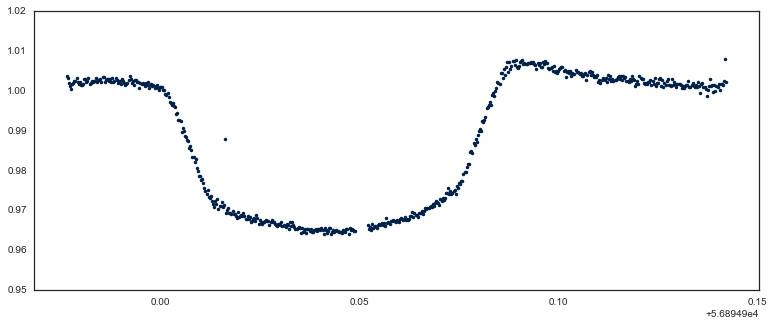

In [5]:
plot(f['mjd-obs'], f.z, '.')
ylim(0.95,1.02)

In [28]:
f.columns

Index([u'mjd-obs', u'elapshut', u'ipa', u'ipa0', u'pa', u'airmass', u'elevat',
       u'rotang', u'pressure', u'tambient', u'center_1', u'amplitude_1',
       u'width_1', u'sky_1', u'center_2', u'amplitude_2', u'width_2', u'sky_2',
       u'g', u'r', u'i', u'z'],
      dtype='object')

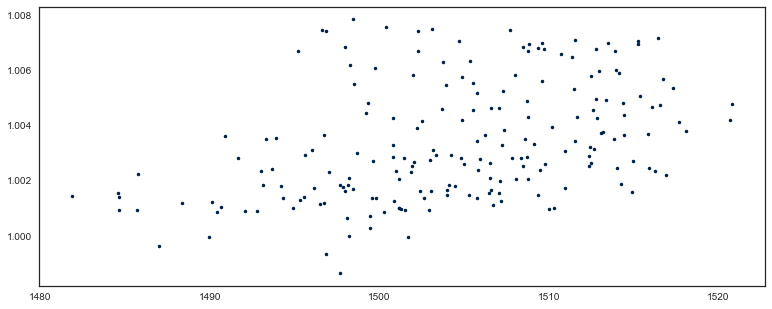

In [44]:
plot(f.sky_1.values[400:],f.z.values[400:], '.')

In [13]:
t = f.z.values[450:570]
x = arange(t.size)
t = t / poly1d(polyfit(x,t,2))(x)

In [15]:
t.std()

0.00060677821316146719

In [16]:
t = t.reshape([-1,10])

In [21]:
t.mean(1).std()

0.00023277089453990453